In [4]:
import os
import numpy as np
import tensorflow as tf
import keras_cv
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

In [5]:
print(tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'))


2.19.0
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
train_data_dir = "asl_alphabet/asl_alphabet_train"
test_data_dir = "asl_alphabet/asl_alphabet_test"

In [7]:
# --- Konfiguracja ---
img_size = (224, 224)
batch_size = 64
AUTOTUNE = tf.data.AUTOTUNE

# --- Augmentacja ---
value_range = (0.0, 1.0)
augmenter = keras_cv.layers.Augmenter([
    keras_cv.layers.RandomZoom(0.05),
    keras_cv.layers.RandomRotation(0.005),
    keras_cv.layers.RandomBrightness(factor=0.2, value_range=value_range),
    keras_cv.layers.RandomContrast(factor=0.2, value_range=value_range),
])

# --- Dataset ---
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
)
class_names = train_ds.class_names
train_ds = train_ds.map(lambda x, y: (augmenter(x / 255.0), y), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (x / 255.0, y), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)



I0000 00:00:1746356625.722940  768720 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1746356625.722992  768720 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.


In [8]:
# --- Model ---

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
     include_top=False,
     weights='imagenet',
     pooling='avg'
)

# --- Fine-tuning ---
base_model.trainable = True
for layer in base_model.layers[:int(len(base_model.layers) * 0.8)]:
    layer.trainable = False


inputs = base_model.input
x = tf.keras.layers.Dense(64, activation='relu')(base_model.output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(29, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])



In [6]:
# --- Trening ---
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("model.keras", save_best_only=True, monitor="val_accuracy", verbose=1),
    tf.keras.callbacks.EarlyStopping(patience=2, monitor="val_accuracy", restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2, min_lr=1e-6, verbose=1),
    tf.keras.callbacks.TensorBoard(log_dir="logs", write_graph=True, write_images=True, histogram_freq=1)
]

model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=callbacks, verbose=1)


Epoch 1/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.7761 - loss: 0.9772
Epoch 1: val_accuracy improved from -inf to 0.99454, saving model to model.keras
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 656s 597ms/step - accuracy: 0.7762 - loss: 0.9766 - val_accuracy: 0.9945 - val_loss: 0.0430 - learning_rate: 1.0000e-04
Epoch 2/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.9977 - loss: 0.0350
Epoch 2: val_accuracy improved from 0.99454 to 0.99914, saving model to model.keras
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 614s 563ms/step - accuracy: 0.9977 - loss: 0.0350 - val_accuracy: 0.9991 - val_loss: 0.0072 - learning_rate: 1.0000e-04
Epoch 3/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.9990 - loss: 0.0154
Epoch 3: val_accuracy improved from 0.99914 to 0.99960, saving model to model.keras
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 611s 561ms/step - accuracy: 0.9990 - loss: 0.0154 - val_accuracy: 0.9996 - val_loss: 0.0036 - learning_rate: 1.0000e-04
Epoch 4/10
1088/1088 ━━━━━━━

In [9]:
# --- Test set ---

class_to_idx = {name: i for i, name in enumerate(class_names)}
test_images, test_labels = [], []

for filename in os.listdir(test_data_dir):
    if filename.endswith(".jpg"):
        label = filename.split("_")[0]
        if label not in class_to_idx:
            continue
        img = load_img(os.path.join(test_data_dir, filename), target_size=img_size)
        arr = img_to_array(img) / 255.0
        test_images.append(arr)
        test_labels.append(class_to_idx[label])

test_images = np.array(test_images)
test_labels = to_categorical(test_labels, num_classes=len(class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0029
Test Loss: 0.0029, Test Accuracy: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


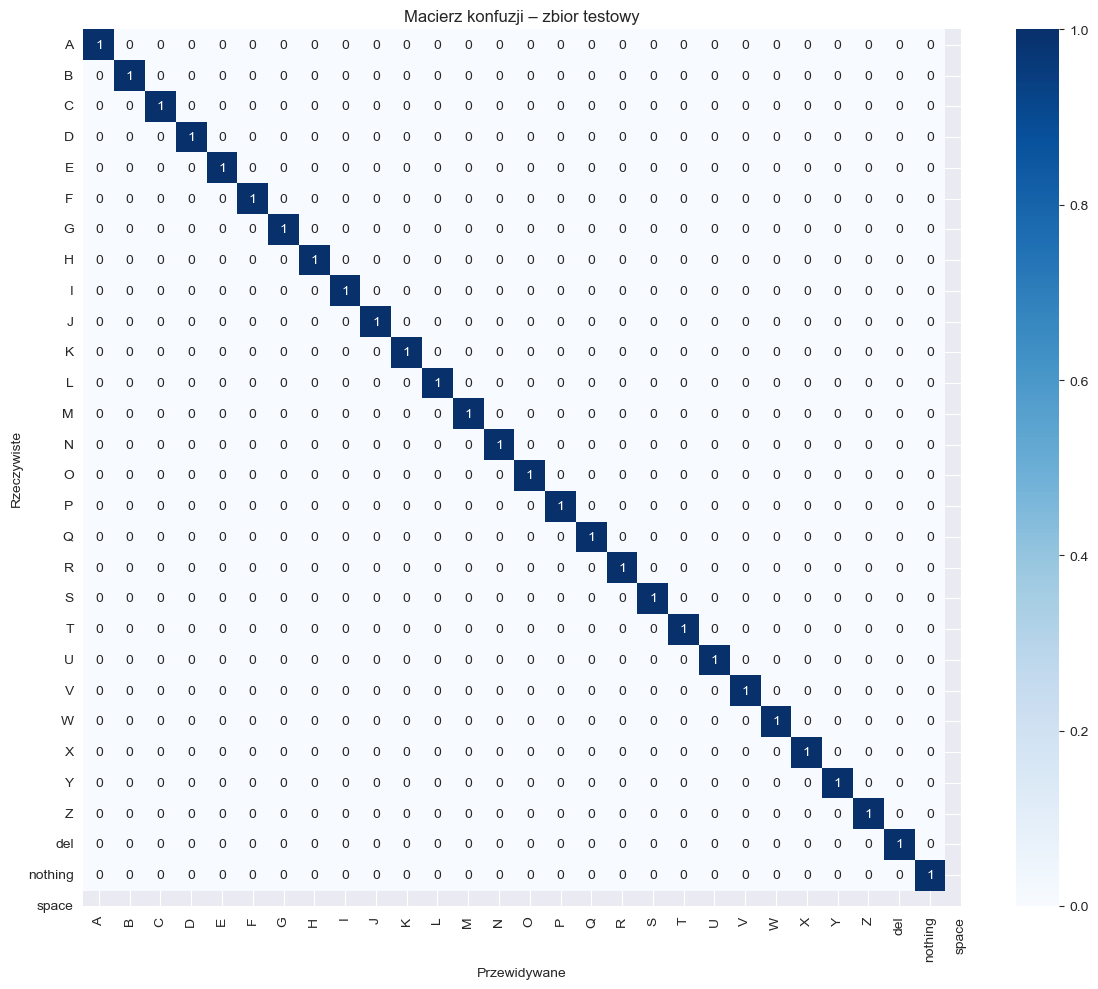

In [10]:
# --- Ewaluacja ---
model = load_model("model.keras")
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

predictions = model.predict(test_images, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Przewidywane")
plt.ylabel("Rzeczywiste")
plt.title("Macierz konfuzji – zbior testowy")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


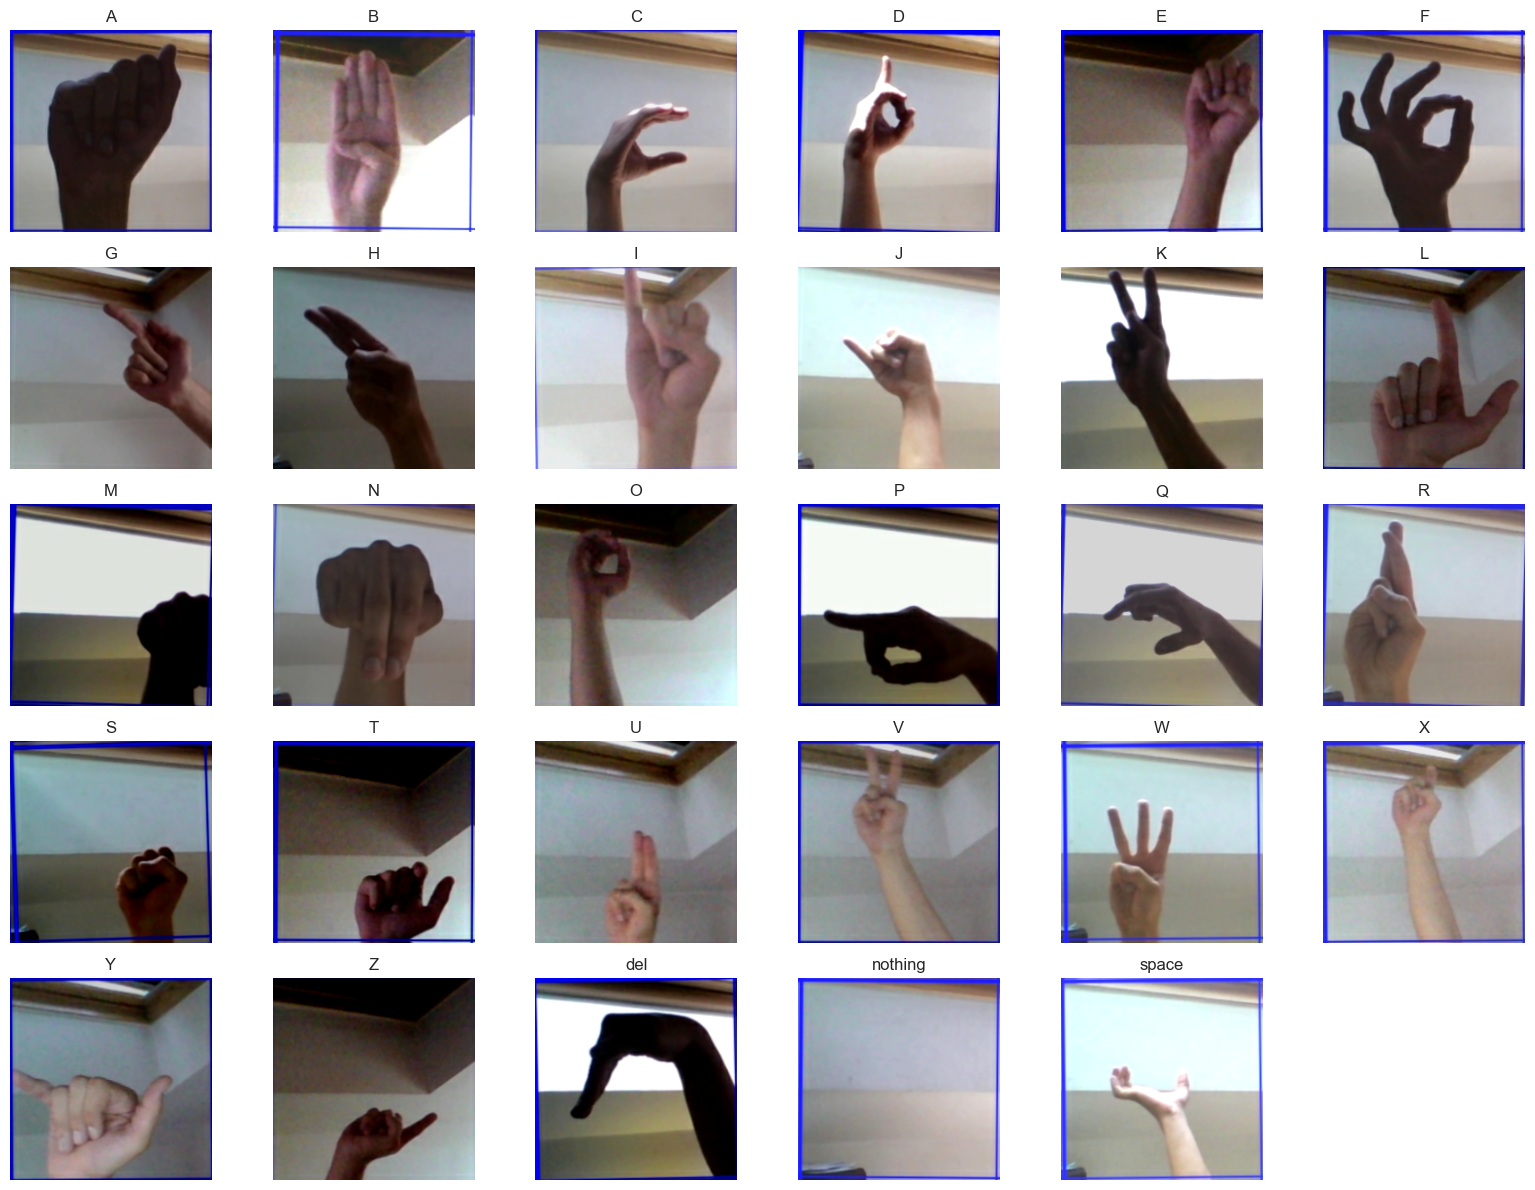

In [16]:
label_to_sample = {}
for images, labels in train_ds.unbatch():
    label_idx = tf.argmax(labels).numpy()
    if label_idx not in label_to_sample:
        label_to_sample[label_idx] = images
    if len(label_to_sample) == len(class_names):
        break

# Sortowanie po nazwach klas
sorted_items = sorted(label_to_sample.items(), key=lambda item: class_names[item[0]])

plt.figure(figsize=(16, 12))
for i, (label_idx, image) in enumerate(sorted_items):
    img = tf.image.convert_image_dtype(image, dtype=tf.float32).numpy()
    plt.subplot(5, 6, i + 1)
    plt.imshow(img)
    plt.title(class_names[label_idx])
    plt.axis("off")
plt.tight_layout()
plt.show()


In [18]:
current_word = ""

cap = cv2.VideoCapture(1) # 0 = domyślna kamera, 1 = zewnętrzna kamera
if not cap.isOpened():
    print("Nie można otworzyć kamery")
    exit()

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
margin = 80

with mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=1,
    min_detection_confidence=0.7,
    min_tracking_confidence=0.5
) as hands:

    predicted_class = ""

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Błąd kamery")
            break

        frame = cv2.flip(frame, 1)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(rgb_frame)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                h, w, _ = frame.shape
                x_coords = [lm.x for lm in hand_landmarks.landmark]
                y_coords = [lm.y for lm in hand_landmarks.landmark]
                x_min = max(int(min(x_coords) * w) - margin, 0)
                y_min = max(int(min(y_coords) * h) - margin, 0)
                x_max = min(int(max(x_coords) * w) + margin, w)
                y_max = min(int(max(y_coords) * h) + margin, h)

                hand_img = frame[y_min:y_max, x_min:x_max]
                hand_img = cv2.resize(hand_img, img_size)
                roi_rgb = cv2.cvtColor(hand_img, cv2.COLOR_BGR2RGB)
                roi_rgb = roi_rgb.astype(np.float32) / 255.0
                roi_rgb = roi_rgb[np.newaxis, ...]

                prediction = model.predict(roi_rgb, verbose=0)
                predicted_class = class_names[np.argmax(prediction)]

                cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                cv2.putText(frame, predicted_class, (x_min, y_min - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                mp_drawing.draw_landmarks(
                    frame, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                    mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),
                    mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2)
                )

        cv2.putText(frame, f"Predykcja: {predicted_class}", (10, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (200, 200, 0), 2)
        cv2.putText(frame, f"Slowo: {current_word}", (10, 90),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 0), 2)

        legend = [
            "Legenda:",
            "'d' - Wyczysc slowo",
            "'Spacja' - Akceptacja predykcji",
            "Gest 'del' - Usun ostatni znak",
            "Gest 'space' - Dodanie spacji",
            "'q' - Wyjscie",
        ]
        h, w, _ = frame.shape
        for i, text in enumerate(legend):
            cv2.putText(frame, text, (10, h - 10 - (len(legend) - i) * 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

        cv2.imshow("Kamera", frame)
        key = cv2.waitKey(1) & 0xFF

        if key == ord('q'):
            break
        elif key == ord('d'):  # D = wyczyść słowo
            current_word = ""
        elif key == 32:  # Spacja = akceptacja gestu
            if predicted_class == "space":
                current_word += " "
            elif predicted_class == "del":
                current_word = current_word[:-1]
            elif predicted_class not in ["nothing"]:
                current_word += predicted_class

cap.release()
cv2.destroyAllWindows()

I0000 00:00:1746358424.501757  768720 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M1
W0000 00:00:1746358424.510726  861215 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1746358424.516038  861215 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
